# Lucas-pricing of AR1 trees

## A notebook by [Mateo Velásquez-Giraldo](https://mv77.github.io/)
### Inspired on its [Quantecon counterpart](https://julia.quantecon.org/multi_agent_models/lucas_model.html)

This notebooks presents simple computational tools to solve Lucas' asset-pricing model when the logarithm of the asset's dividend follows an autoregressive process of order 1.

\begin{equation*}
\ln d_{t+1} = \alpha \ln d_t + \varepsilon_{t+1}
\end{equation*}

A presentation of this model can be found in [Christopher D. Carroll's lecture notes](http://www.econ2.jhu.edu/people/ccarroll/public/lecturenotes/AssetPricing/LucasAssetPrice/). The pricing equation is:

\begin{equation*}
P^*(d_t) = E_{t}\left[ \frac{u(d_{t+1})}{u(d_t)} (P^*(d_{t+1}) + d_{t+1}) \right]
\end{equation*}

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from copy import copy

from HARK.utilities import CRRAutilityP
from HARK.distribution import Normal
from HARK.interpolation import LinearInterp, ConstantFunction

In [2]:
class DivProcess:
    
    def __init__(self, alpha, shock_sd, nApprox = 7):
        
        self.alpha = alpha
        self.shock_sd = shock_sd
        self.nApprox = nApprox
        
        # Create a discrete approximation to the random shock
        self.ShkAppDstn = Normal(sigma = shock_sd).approx(N = nApprox)
        
class LucasEconomy:
    
    def __init__(self, CRRA, DiscFac, DivProcess):
        
        self.CRRA = CRRA
        self.DiscFac = DiscFac
        self.DivProcess = DivProcess
        self.uP = lambda c: CRRAutilityP(c, self.CRRA)
        
    def priceOnePeriod(self, Pfunc_next, logDGrid):
        
        # Create 'tiled arrays' rows are state today, columns are value of
        # tomorrow's shock
        dGrid_N = len(logDGrid)
        shock_N = self.DivProcess.nApprox
        
        # Today's dividends
        logD_now = np.tile(np.reshape(logDGrid, (dGrid_N,1)),
                           (1,shock_N))
        d_now = np.exp(logD_now)
        
        # Tomorrow's dividends
        Shk_next = np.tile(self.DivProcess.ShkAppDstn.X,
                               (dGrid_N, 1))
        Shk_next_pmf = np.tile(self.DivProcess.ShkAppDstn.pmf,
                               (dGrid_N, 1))
        
        logD_next = self.DivProcess.alpha * logD_now + Shk_next
        d_next = np.exp(logD_next)
        
        # Tomorrow's prices
        P_next = Pfunc_next(logD_next)
        
        # Compute the RHS of the pricing equation, pre-expectation
        SDF = self.DiscFac * self.uP(d_next / d_now)
        Payoff_next = P_next + d_next
        
        # Take expectation and discount
        P_now = np.sum(SDF*Payoff_next*Shk_next_pmf, axis = 1, keepdims=True)
        
        # Create new interpolating price function
        Pfunc_now = LinearInterp(logDGrid, P_now.flatten(), lower_extrap=True)
        
        return(Pfunc_now)
        
    def solve(self, Pfunc_0 = None, logDGrid = None, tol = 1e-5, maxIter = 500, disp = False):
        
        # Initialize the norm
        norm = tol + 1
        
        # Initialize Pfunc if initial guess is not provided
        if Pfunc_0 is None:
            Pfunc_0 = ConstantFunction(0.0)
        
        # Create a grid for log-dividends if one is not provided
        if logDGrid is None:
            uncond_sd = self.DivProcess.shock_sd / np.sqrt(1 - self.DivProcess.alpha**2)
            logDGrid = np.linspace(-5*uncond_sd, 5*uncond_sd, 100)
        
        # Initialize function and compute prices on the grid
        Pf_0 = copy(Pfunc_0)
        P_0 = Pf_0(logDGrid)
        
        it = 0
        while norm > tol and it < maxIter:
            
            # Apply the pricing equation
            Pf_next = self.priceOnePeriod(Pf_0, logDGrid)
            # Find new prices on the grid
            P_next = Pf_next(logDGrid)
            # Measure the change between price vectors
            norm = np.linalg.norm(P_0 - P_next)
            # Update price function and vector
            Pf_0 = Pf_next
            P_0  = P_next
            it = it + 1
            # Print iteration information
            if disp:
                print('Iter:' + str(it) + '   Norm = '+ str(norm))
        
        if disp:
            if norm <= tol:
                print('Price function converged!')
            else:
                print('Maximum iterations exceeded!')
        
        self.EqlogPfun = Pf_0
        self.EqPfun = lambda d: self.EqlogPfun(np.log(d))

# An example economy

An economy is fully specified by:
- **The dividend process for the assets (trees)**: we assume that $\ln d_{t+1} = \alpha \ln d_t + \varepsilon_{t+1}$. We must create a dividend process specifying $\alpha$ and $\sigma_{\varepsilon}$.
- **The coefficient of relative risk aversion (CRRA).**
- **The time-discount factor ($\beta$).**

In [3]:
# Create a log-AR1 process for dividends
DivProc = DivProcess(alpha = 0.90, shock_sd = 0.1)

# Create an example economy
economy = LucasEconomy(CRRA = 2, DiscFac = 0.95, DivProcess = DivProc)

Once created, the economy can be 'solved', which means finding the equilibrium price function. The distribution of dividends at period $t+1$ depends on the value of dividends at $t$. Thus, $d_t$ is a state variable for the economy. The pricing function gives the price of trees that equates their demand and supply at every level of current dividends $d_t$.

In [4]:
# Solve the economy
economy.solve(disp = True)

# After the economy is solved, we can use its Equilibrium price function
d = 1
print('P({}) = {}'.format(d, economy.EqPfun(d)))

Iter:1   Norm = 15.078492707888971
Iter:2   Norm = 15.364187550629122
Iter:3   Norm = 15.574184260513519
Iter:4   Norm = 15.705321834094176
Iter:5   Norm = 15.758153638835239
Iter:6   Norm = 15.73588081854969
Iter:7   Norm = 15.643515942992448
Iter:8   Norm = 15.487249547338951
Iter:9   Norm = 15.273939284634384
Iter:10   Norm = 15.010720323462312
Iter:11   Norm = 14.704712752277215
Iter:12   Norm = 14.362808402479406
Iter:13   Norm = 13.991522607681395
Iter:14   Norm = 13.59689781058941
Iter:15   Norm = 13.18444788932241
Iter:16   Norm = 12.759133681902245
Iter:17   Norm = 12.325361778696157
Iter:18   Norm = 11.887000083698242
Iter:19   Norm = 11.447404920433039
Iter:20   Norm = 11.009455566257232
Iter:21   Norm = 10.575593039092091
Iter:22   Norm = 10.147860743036276
Iter:23   Norm = 9.727945217684864
Iter:24   Norm = 9.317215747420896
Iter:25   Norm = 8.916761989301403
Iter:26   Norm = 8.527429088845741
Iter:27   Norm = 8.149849988184098
Iter:28   Norm = 7.784474805011756
Iter:29   

## The effect of risk aversion

Text(0, 0.5, '$P_t$')

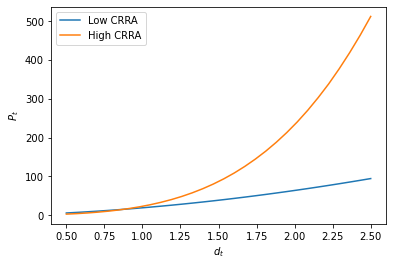

In [5]:
# Create two economies with different risk aversion
Disc = 0.95
LowCrraEcon  = LucasEconomy(CRRA = 2, DiscFac = Disc, DivProcess = DivProc)
HighCrraEcon = LucasEconomy(CRRA = 4, DiscFac = Disc, DivProcess = DivProc)

# Solve both
LowCrraEcon.solve()
HighCrraEcon.solve()

# Plot the pricing functions for both
dGrid = np.linspace(0.5,2.5,30)
plt.plot(dGrid, LowCrraEcon.EqPfun(dGrid), label = 'Low CRRA')
plt.plot(dGrid, HighCrraEcon.EqPfun(dGrid), label = 'High CRRA')
plt.legend()
plt.xlabel('$d_t$')
plt.ylabel('$P_t$')